In [1]:
import sys
import os

import joblib
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, tune

In [4]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, encode_labels, train_val_split, \
    get_dimensions, get_device, metrics_c, plot_history, load_best_params, load_tuning_history, print_best_params_nn, \
    save_best_params, save_tuning_history, print_tuning_top_results, plot_param_loss_corr, plot_tuning_heatmap, \
    read_target_tensors

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
# Data Path
path_features = os.path.abspath(os.path.join(os.getcwd(), "../../../data/features2"))
path_targets = os.path.abspath(os.path.join(os.getcwd(), "../../../data/targets/classification"))

# Model Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))
os.makedirs(path_models, exist_ok=True)

In [7]:
target = "HistoricalPeriod"

## Data

### Read Features and Targets

In [8]:
X = read_features(path_features, f_type="tensors")
print_info_features(X)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_val_tfidf
Loaded X_val_bert
Loaded X_val_cannyhog
Loaded X_val_resnet
Loaded X_val_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<

In [9]:
y = read_target_tensors(path_targets)
print_info_targets(y)

Loaded y_train
Loaded y_val
Loaded y_test
{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1528])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191])
}


### Load Target Encoder

In [10]:
path_encoder = os.path.join(path_targets, "y_encoder.pkl")
y_encoder = joblib.load(path_encoder)

### Dimensions

In [11]:
X_dim, y_dim = get_dimensions(X, y, y_encoder)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 4


### Torch Datasets and Dataloaders

In [12]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Define Parameter Grid

In [13]:
criterion = nn.CrossEntropyLoss()
metrics = metrics_c
log_metrics = ["accuracy"]

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [128, 256, 512, 1024],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.05, 0.1, 0.2],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [1, 2, 3],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-2, 5e-3, 1e-3, 5e-4],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
}

## Load or Initialize Best Params & Tuning History

In [14]:
# Load or initialize best params dictionary and tuning history table
path_params = os.path.join(path_models, "best_params.json")
path_history = os.path.join(path_models, "tuning_history.csv")

best_params = load_best_params(path_params)
print(f"Best Params Available for {len(best_params.keys())} Models")

tuning_histories = load_tuning_history(path_history)

Best Params Available for 0 Models


## Run Model Tuning



In [15]:
flag_new_model = False

def tune_helper(fts):
    global flag_new_model, best_params, tuning_histories
    ft = " + ".join(fts)

    if ft not in best_params.keys():
        flag_new_model = True
        print(f"\n🔄 Tuning MLP with '{ft.upper()}' Features")
        tuning_result, tuning_history = tune(
            param_grid,
            [X_dim[_ft] for _ft in fts],
            y_dim,
            loaders["train"][ft],
            loaders["val"][ft],
            criterion,
            metrics,
            device,
            log_metrics=log_metrics,
            log_per_M=100,
            chronology_target="periods"
        )

        best_params[ft] = tuning_result
        tuning_histories[ft] = tuning_history
    else:
        print(f"\n✅ MLP with '{ft.upper()}' Features Already Tuned.", end=" ")
        print_best_params_nn(best_params[ft], param_grid, y_dim, log_metrics)

for ft in feature_types:
    tune_helper([ft])

for ft_txt, ft_img in feature_type_combos:
    tune_helper([ft_txt, ft_img])


🔄 Tuning MLP with 'TFIDF' Features
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+------------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss | accuracy_0 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+------------+
|   001/576 |         128 |       relu |    0.05 |      1 |          decreasing |   0.01 |    0.5442 |     0.7487 | *
|   002/576 |         128 |       relu |    0.05 |      1 |          decreasing |  0.005 |    0.5528 |     0.7435 |
|   003/576 |         128 |       relu |    0.05 |      1 |          decreasing |  0.001 |    0.5343 |     0.7435 | *
|   004/576 |         128 |       relu |    0.05 |      1 |          decreasing | 0.0005 |    0.5192 |     0.7539 | *
///////////////////
|   024/576 |         512 |       relu |    0.05 |      1 |            constant | 0.0005 |    0.5180 |     0.7487 | *
////////

## Save Best Params & Tuning History

In [17]:
save_best_params(path_params, best_params, flag_new_model)
save_tuning_history(path_history, tuning_histories, flag_new_model)

✅ Saved best parameters to C:\Users\dimit\PycharmProjects\AgoraPottery\02_chronology_prediction\NN\classification2\models\best_params.json
✅ Saved tuning history to C:\Users\dimit\PycharmProjects\AgoraPottery\02_chronology_prediction\NN\classification2\models\tuning_history.csv


## Evaluate Tuning Results

(0.4802238643169403, 0.8609958291053772)


📈 Tuning results for TFIDF features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
60,relu,1,0.10,1024,constant,0.010,0.720586,0.501543,0.753927,0.371915,0.371244,0.369838
396,gelu,2,0.05,256,constant,0.010,0.418995,0.502785,0.795812,0.394162,0.396983,0.394770
360,gelu,1,0.20,256,decreasing,0.010,0.478822,0.505290,0.769634,0.383358,0.383374,0.382453
557,gelu,3,0.20,256,constant,0.005,0.514456,0.508259,0.780105,0.383818,0.389101,0.386014
461,gelu,2,0.20,256,constant,0.005,0.536229,0.509087,0.753927,0.442300,0.433005,0.435911



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
396,gelu,2,0.05,256,constant,0.010,0.418995,0.502785,0.795812,0.394162,0.396983,0.394770
28,relu,1,0.05,1024,constant,0.010,0.462722,0.543029,0.795812,0.392089,0.408313,0.399251
528,gelu,3,0.10,512,decreasing,0.010,0.820162,0.565598,0.790576,0.389134,0.400493,0.394716
186,relu,2,0.20,1024,decreasing,0.001,0.620954,0.536270,0.790576,0.391164,0.410406,0.397901
440,gelu,2,0.10,1024,decreasing,0.010,0.599817,0.578488,0.790576,0.389269,0.404741,0.396253


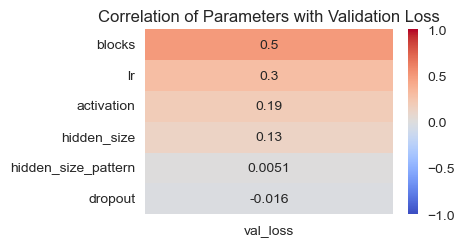

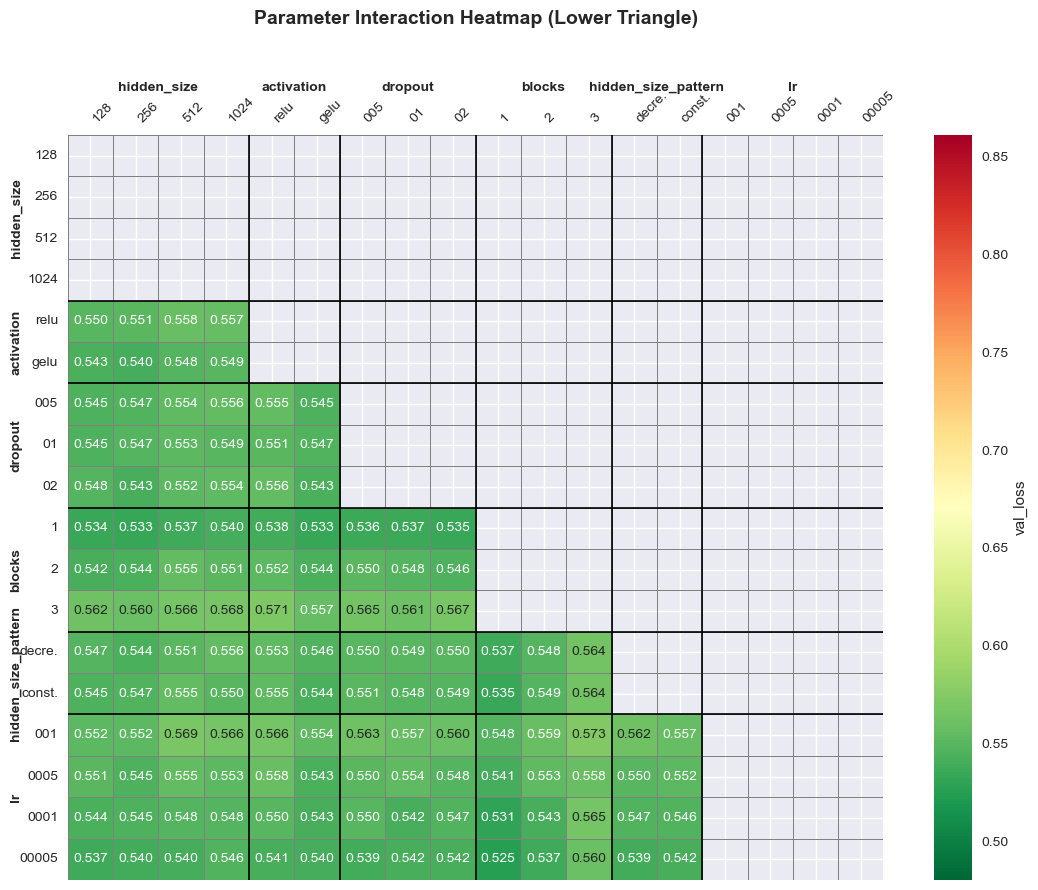



📈 Tuning results for BERT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
457,gelu,2,0.2,256,decreasing,0.005,0.657368,0.642287,0.722513,0.363128,0.344150,0.343860
164,relu,2,0.2,128,constant,0.010,0.672129,0.643909,0.717277,0.373689,0.333498,0.331273
452,gelu,2,0.2,128,constant,0.010,0.632435,0.644583,0.712042,0.355860,0.338424,0.337604
161,relu,2,0.2,128,decreasing,0.005,0.637783,0.648426,0.696335,0.340869,0.336207,0.334805
133,relu,2,0.1,128,constant,0.005,0.619530,0.648930,0.706806,0.359101,0.333436,0.333248



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
140,relu,2,0.10,256,constant,0.010,0.630751,0.670340,0.759162,0.382943,0.367734,0.368726
212,relu,3,0.05,512,constant,0.010,0.573663,0.727969,0.743455,0.390265,0.351355,0.352609
109,relu,2,0.05,256,constant,0.005,0.583361,0.680344,0.738220,0.375155,0.352032,0.352545
96,relu,2,0.05,128,decreasing,0.010,0.661517,0.680402,0.732984,0.375122,0.347044,0.347152
281,relu,3,0.20,1024,decreasing,0.005,0.675652,0.687031,0.722513,0.363128,0.344150,0.343860


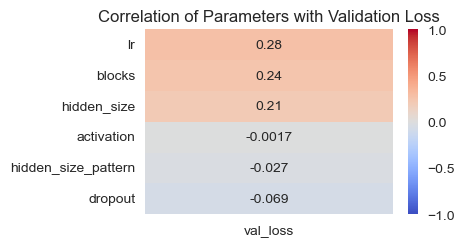

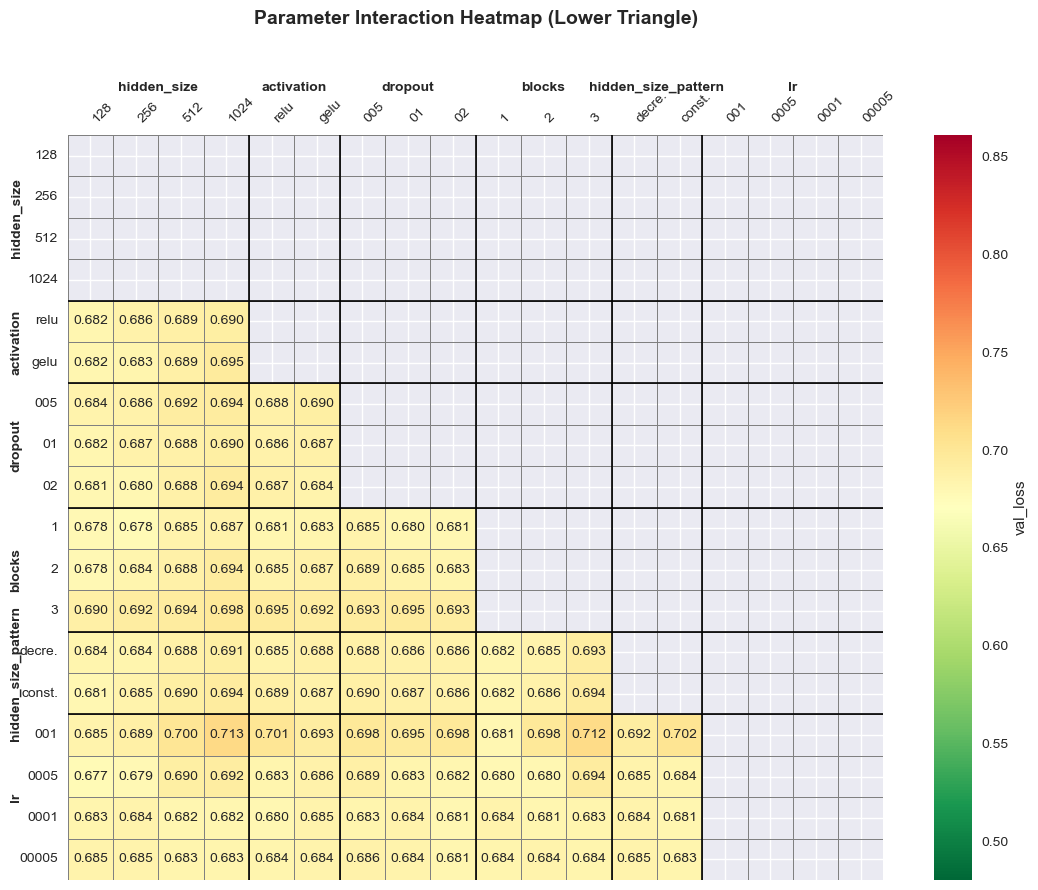



📈 Tuning results for CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
327,gelu,1,0.10,128,constant,0.0005,0.620057,0.723006,0.659686,0.591293,0.353140,0.375400
294,gelu,1,0.05,128,constant,0.0010,0.581993,0.724852,0.649215,0.457131,0.348830,0.355668
306,gelu,1,0.05,512,decreasing,0.0010,0.648446,0.725178,0.664921,0.600735,0.355296,0.377389
35,relu,1,0.10,128,decreasing,0.0005,0.671680,0.726806,0.638743,0.311145,0.284175,0.268664
349,gelu,1,0.10,1024,constant,0.0050,0.615395,0.727141,0.659686,0.583636,0.355973,0.381645



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
342,gelu,1,0.10,512,constant,0.0010,0.620554,0.735614,0.664921,0.600735,0.355296,0.377389
318,gelu,1,0.05,1024,constant,0.0010,0.587415,0.746667,0.664921,0.607235,0.353879,0.373990
335,gelu,1,0.10,256,constant,0.0005,0.646955,0.736686,0.664921,0.607235,0.353879,0.373990
303,gelu,1,0.05,256,constant,0.0005,0.638542,0.730076,0.664921,0.607235,0.353879,0.373990
306,gelu,1,0.05,512,decreasing,0.0010,0.648446,0.725178,0.664921,0.600735,0.355296,0.377389


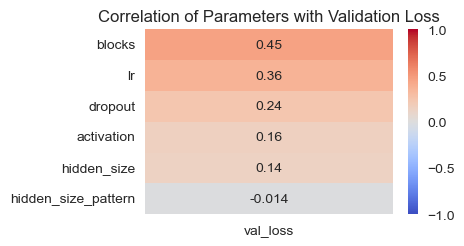

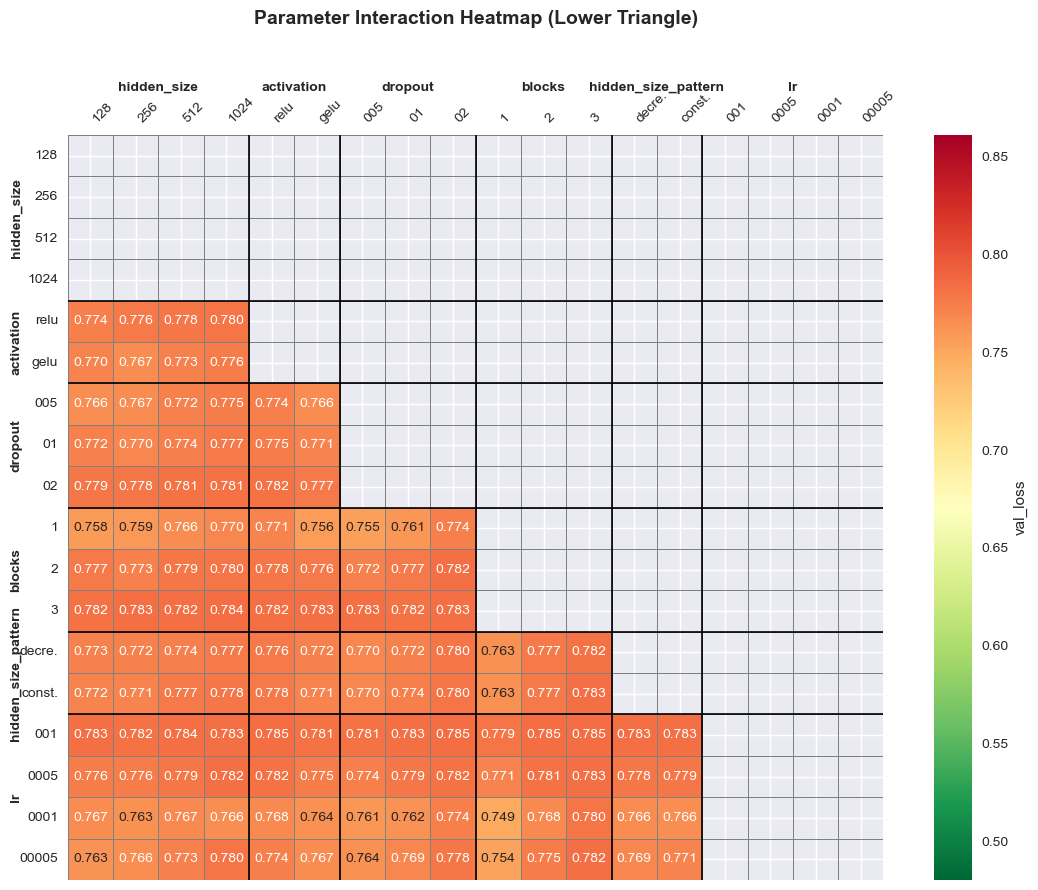



📈 Tuning results for RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
429,gelu,2,0.1,256,constant,0.005,0.735999,0.718461,0.664921,0.341754,0.297783,0.284772
236,relu,3,0.1,256,constant,0.010,0.624116,0.720606,0.680628,0.355165,0.305665,0.293625
133,relu,2,0.1,128,constant,0.005,0.643186,0.723486,0.643979,0.317783,0.291995,0.283840
74,relu,1,0.2,256,decreasing,0.001,0.645074,0.724158,0.664921,0.332825,0.299200,0.287426
42,relu,1,0.1,256,decreasing,0.001,0.644258,0.725159,0.659686,0.321839,0.297044,0.285154



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
428,gelu,2,0.10,256,constant,0.010,0.663427,0.726916,0.691099,0.622700,0.370320,0.396770
461,gelu,2,0.20,256,constant,0.005,0.592013,0.738007,0.680628,0.494048,0.364594,0.373923
236,relu,3,0.10,256,constant,0.010,0.624116,0.720606,0.680628,0.355165,0.305665,0.293625
474,gelu,2,0.20,1024,decreasing,0.001,0.549805,0.747478,0.680628,0.476404,0.367426,0.379424
484,gelu,3,0.05,128,constant,0.010,0.653528,0.734789,0.675393,0.367087,0.302094,0.289211


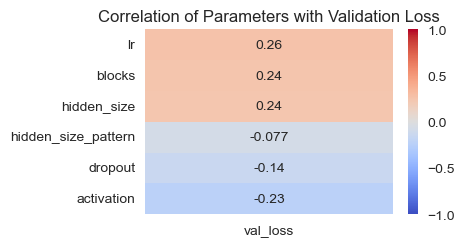

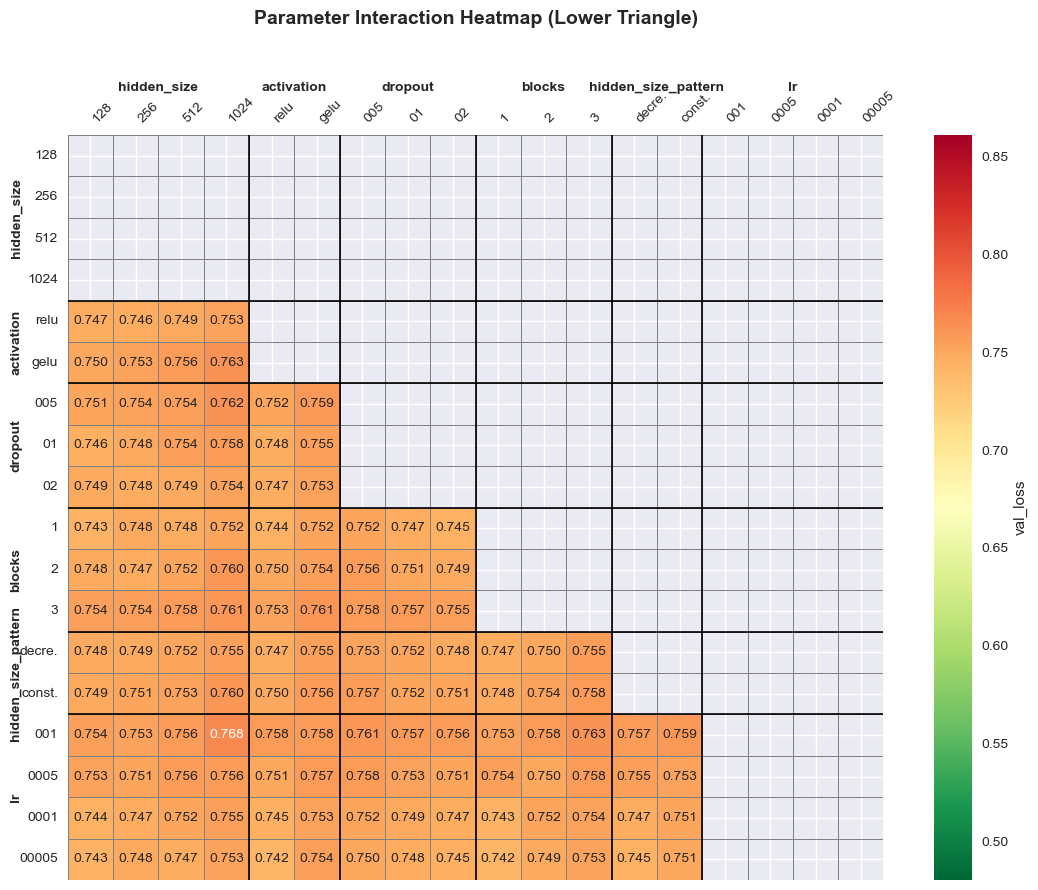



📈 Tuning results for VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
61,relu,1,0.1,1024,constant,0.005,0.555319,0.637141,0.680628,0.519554,0.429187,0.440896
85,relu,1,0.2,512,constant,0.005,0.572242,0.641994,0.691099,0.530366,0.434914,0.447855
245,relu,3,0.1,512,constant,0.005,0.636757,0.642176,0.685864,0.499205,0.429926,0.423579
44,relu,1,0.1,256,constant,0.010,0.607043,0.642856,0.675393,0.429543,0.369520,0.374479
56,relu,1,0.1,1024,decreasing,0.010,0.604542,0.642936,0.685864,0.615085,0.369581,0.397872



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
552,gelu,3,0.20,256,decreasing,0.010,0.697467,0.668909,0.701571,0.360456,0.322783,0.317647
501,gelu,3,0.05,512,constant,0.005,0.568782,0.694987,0.701571,0.546912,0.439224,0.452308
372,gelu,1,0.20,512,constant,0.010,0.566568,0.650253,0.701571,0.622168,0.439224,0.474966
574,gelu,3,0.20,1024,constant,0.001,0.608203,0.684524,0.701571,0.553755,0.437808,0.449672
504,gelu,3,0.05,1024,decreasing,0.010,0.657814,0.660101,0.696335,0.605208,0.378140,0.409275


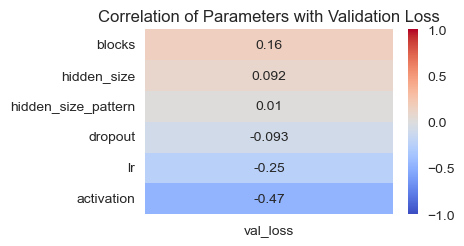

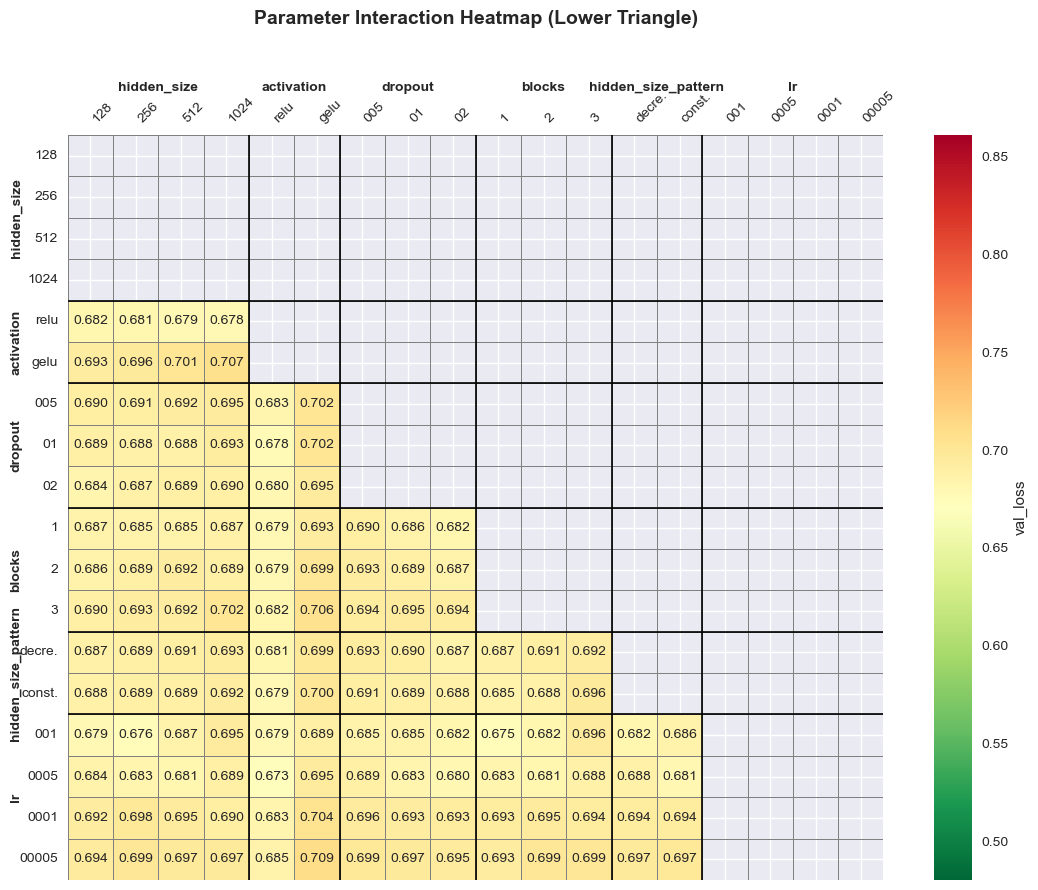



📈 Tuning results for TFIDF + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
397,gelu,2,0.05,256,constant,0.0050,0.437908,0.509913,0.759162,0.500687,0.437993,0.458295
71,relu,1,0.20,128,constant,0.0005,0.451513,0.511178,0.769634,0.379805,0.381958,0.379900
121,relu,2,0.05,1024,decreasing,0.0050,0.387052,0.512280,0.785340,0.387651,0.395505,0.391436
34,relu,1,0.10,128,decreasing,0.0010,0.461101,0.513199,0.759162,0.373347,0.381897,0.377532
156,relu,2,0.10,1024,constant,0.0100,0.560322,0.513935,0.790576,0.390842,0.394828,0.392225



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
286,relu,3,0.20,1024,constant,0.0010,0.482816,0.556705,0.801047,0.395394,0.400554,0.397516
119,relu,2,0.05,512,constant,0.0005,0.609343,0.587608,0.795812,0.396721,0.395566,0.394588
159,relu,2,0.10,1024,constant,0.0005,0.590329,0.618238,0.795812,0.395616,0.396983,0.395276
545,gelu,3,0.20,128,decreasing,0.0050,0.566159,0.535811,0.790576,0.638183,0.459421,0.492500
106,relu,2,0.05,256,decreasing,0.0010,0.584560,0.535924,0.790576,0.389349,0.399076,0.394143


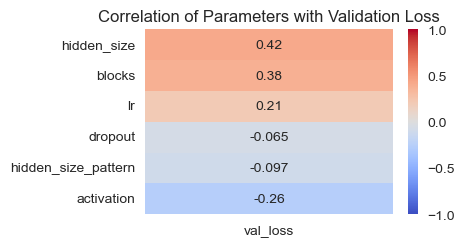

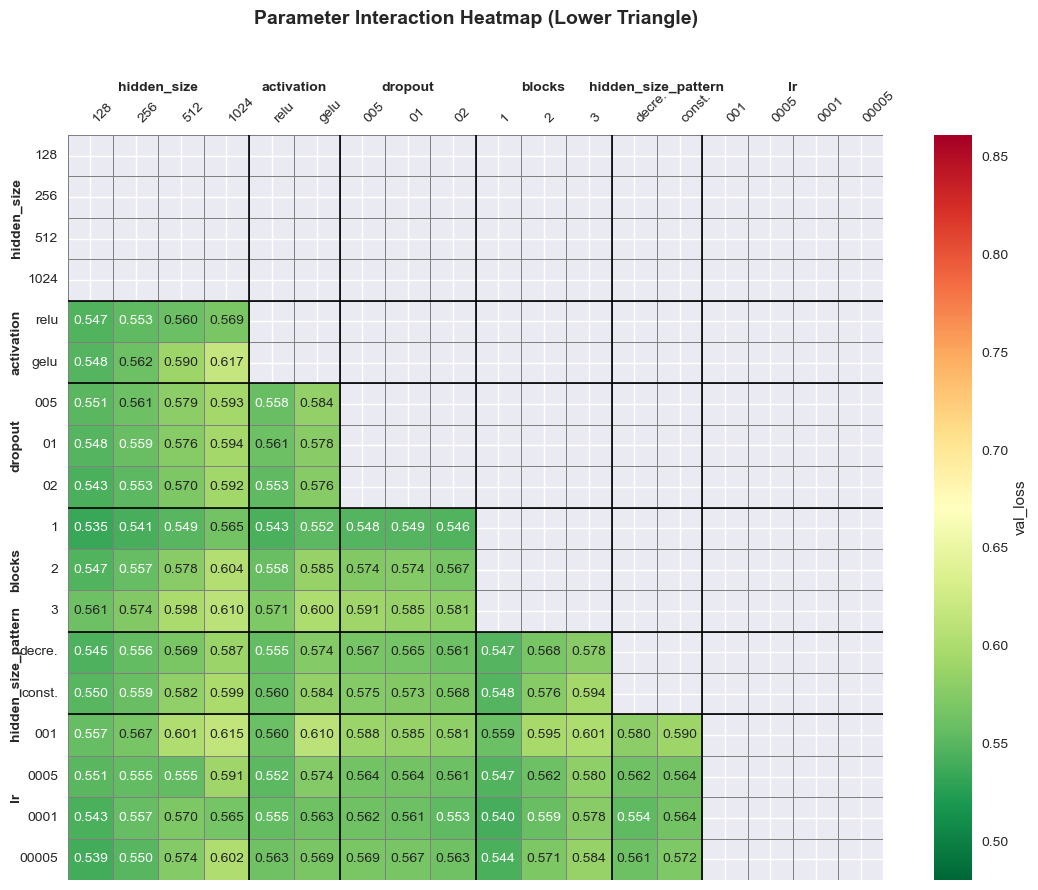



📈 Tuning results for TFIDF + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
337,gelu,1,0.10,512,decreasing,0.0050,0.474791,0.497302,0.764398,0.462550,0.444397,0.451943
313,gelu,1,0.05,1024,decreasing,0.0050,0.524236,0.500140,0.785340,0.512750,0.458682,0.475153
85,relu,1,0.20,512,constant,0.0050,0.482404,0.504921,0.759162,0.372242,0.377648,0.374512
320,gelu,1,0.10,128,decreasing,0.0100,0.498726,0.505826,0.753927,0.370663,0.374076,0.371614
63,relu,1,0.10,1024,constant,0.0005,0.437705,0.506517,0.769634,0.377425,0.389039,0.383092



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
564,gelu,3,0.20,512,constant,0.010,0.588198,0.565566,0.801047,0.394228,0.400554,0.397065
134,relu,2,0.10,128,constant,0.001,0.539340,0.521290,0.795812,0.391501,0.406897,0.398446
377,gelu,1,0.20,1024,decreasing,0.005,0.475888,0.523573,0.790576,0.390260,0.399076,0.394575
220,relu,3,0.05,1024,constant,0.010,0.508105,0.596035,0.790576,0.388539,0.399076,0.393737
254,relu,3,0.10,1024,constant,0.001,0.284974,0.570864,0.790576,0.388964,0.404741,0.395918


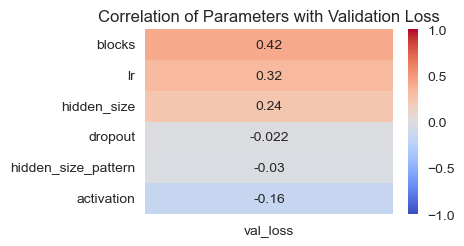

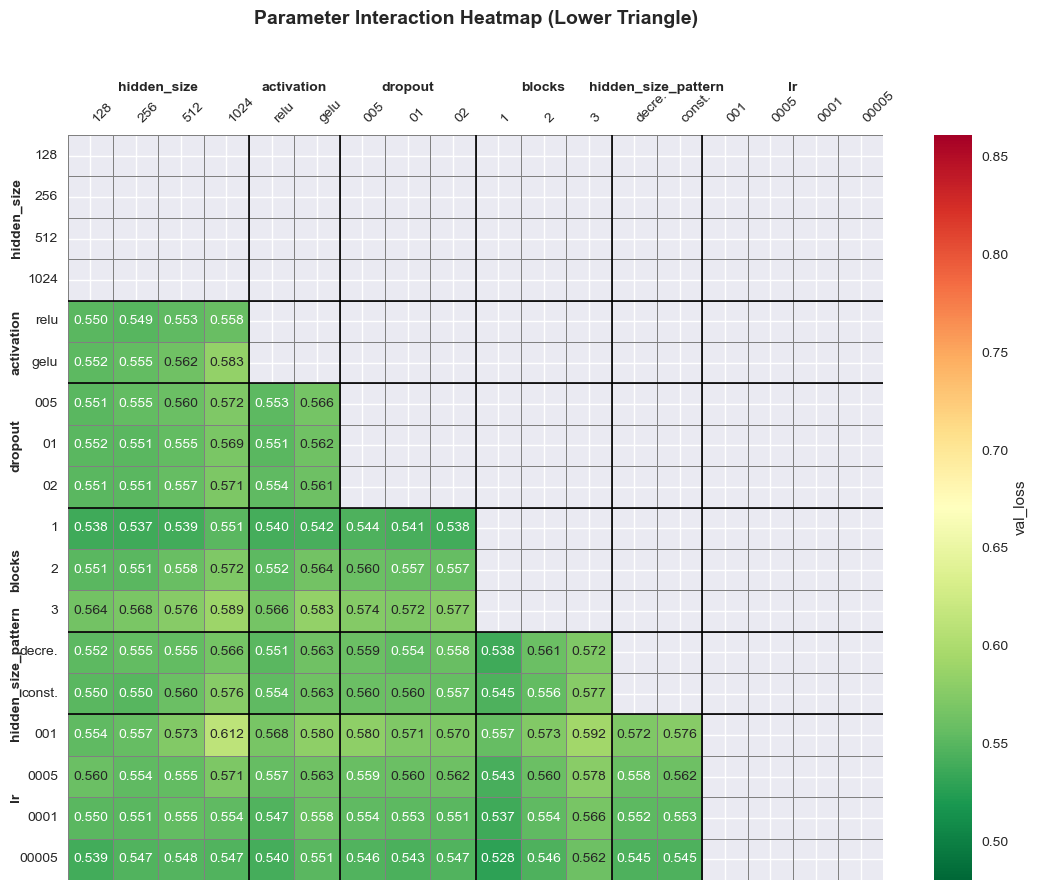



📈 Tuning results for TFIDF + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
456,gelu,2,0.20,256,decreasing,0.0100,0.442574,0.480224,0.780105,0.552502,0.509791,0.527748
288,gelu,1,0.05,128,decreasing,0.0100,0.486603,0.486627,0.753927,0.369937,0.382574,0.375956
91,relu,1,0.20,1024,decreasing,0.0005,0.496817,0.489124,0.780105,0.383818,0.389101,0.386014
374,gelu,1,0.20,512,constant,0.0010,0.484076,0.493343,0.790576,0.388754,0.397660,0.393113
187,relu,2,0.20,1024,decreasing,0.0005,0.540029,0.493734,0.795812,0.391750,0.399815,0.395638



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
558,gelu,3,0.20,256,constant,0.0010,0.422742,0.572457,0.806283,0.571176,0.519150,0.539866
103,relu,2,0.05,128,constant,0.0005,0.435008,0.510838,0.806283,0.397422,0.405542,0.401336
567,gelu,3,0.20,512,constant,0.0005,0.498405,0.525062,0.806283,0.399364,0.408374,0.403816
351,gelu,1,0.10,1024,constant,0.0005,0.418725,0.501488,0.801047,0.523810,0.459483,0.480354
450,gelu,2,0.20,128,decreasing,0.0010,0.423969,0.531388,0.801047,0.644467,0.462315,0.496967


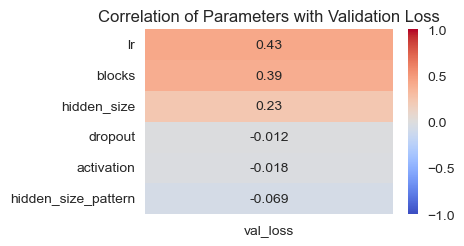

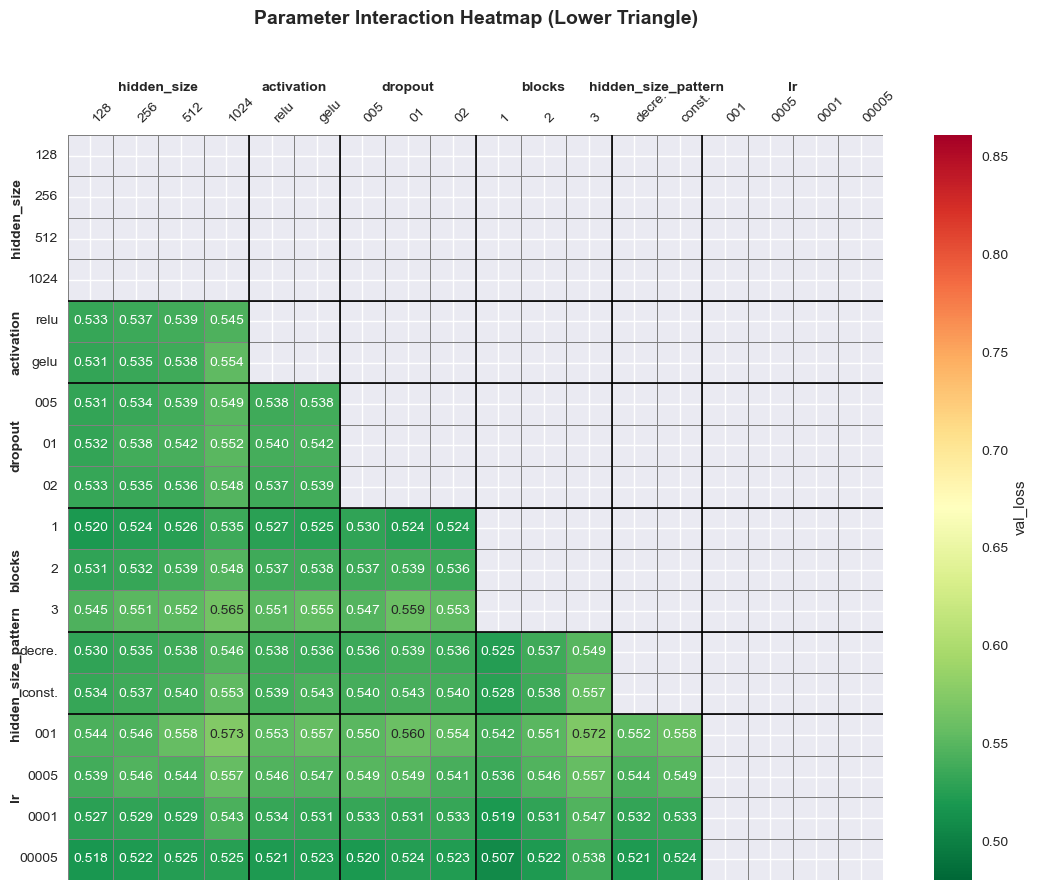



📈 Tuning results for BERT + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
116,relu,2,0.05,512,constant,0.010,0.663579,0.644137,0.706806,0.354746,0.333436,0.332042
278,relu,3,0.20,512,constant,0.001,0.540000,0.644747,0.691099,0.586786,0.390148,0.426693
417,gelu,2,0.10,128,decreasing,0.005,0.545946,0.646151,0.675393,0.455578,0.400677,0.417424
133,relu,2,0.10,128,constant,0.005,0.634175,0.646610,0.701571,0.356134,0.327032,0.324316
28,relu,1,0.05,1024,constant,0.010,0.614260,0.648727,0.701571,0.345238,0.336946,0.335808



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
121,relu,2,0.05,1024,decreasing,0.005,0.662543,0.665405,0.732984,0.377994,0.345628,0.345560
12,relu,1,0.05,256,constant,0.010,0.672765,0.706050,0.732984,0.375122,0.347044,0.347152
561,gelu,3,0.20,512,decreasing,0.005,0.591674,0.661936,0.727749,0.375473,0.342057,0.341491
92,relu,1,0.20,1024,constant,0.010,0.614953,0.670739,0.727749,0.364110,0.349138,0.349077
420,gelu,2,0.10,128,constant,0.010,0.561198,0.676021,0.727749,0.447764,0.413732,0.425103


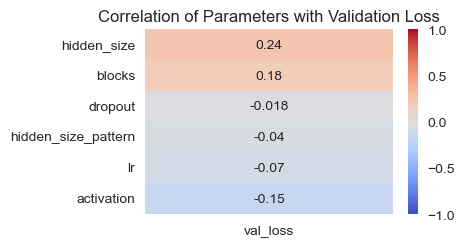

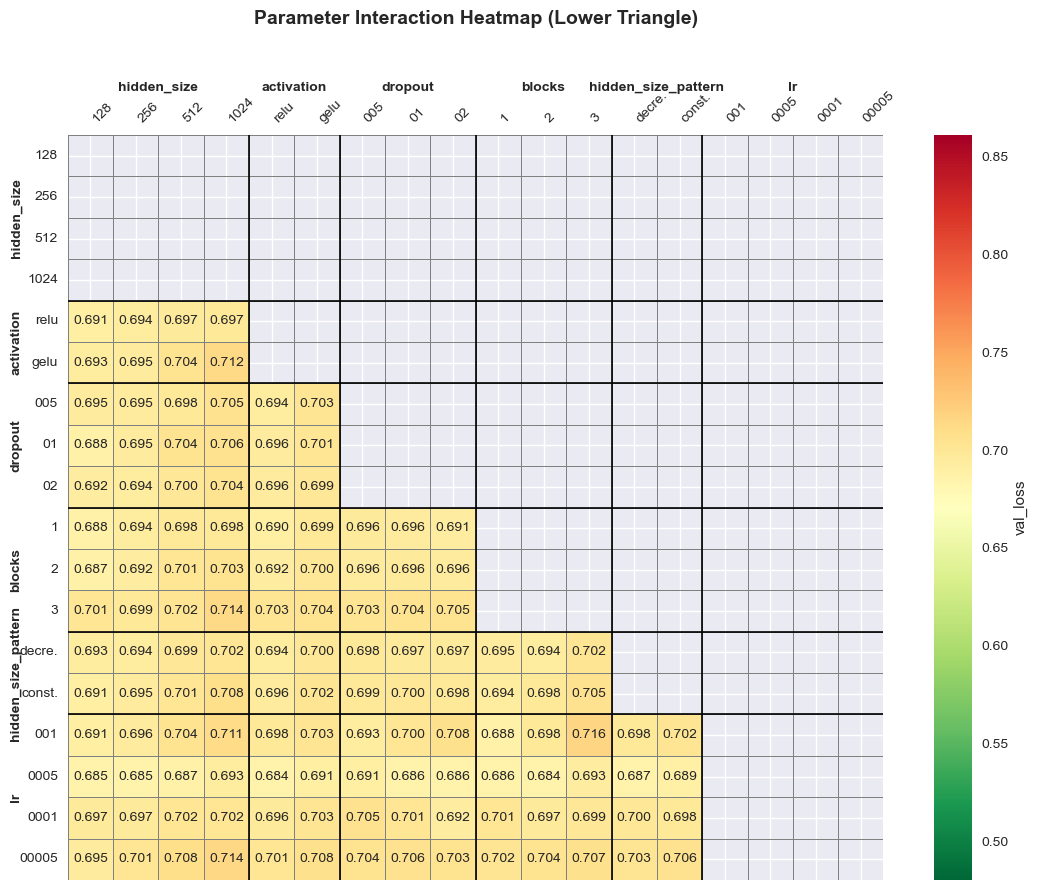



📈 Tuning results for BERT + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
296,gelu,1,0.05,256,decreasing,0.0100,0.546523,0.629480,0.738220,0.362996,0.359113,0.357949
356,gelu,1,0.20,128,constant,0.0100,0.491801,0.633973,0.732984,0.487939,0.418719,0.440410
531,gelu,3,0.10,512,decreasing,0.0005,0.581489,0.646680,0.717277,0.477883,0.408005,0.429333
65,relu,1,0.20,128,decreasing,0.0050,0.519726,0.647151,0.706806,0.344200,0.349015,0.346067
233,relu,3,0.10,256,decreasing,0.0050,0.584360,0.647968,0.691099,0.339943,0.325554,0.323010



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
60,relu,1,0.1,1024,constant,0.0100,0.424825,0.669902,0.759162,0.499903,0.433744,0.454840
52,relu,1,0.1,512,constant,0.0100,0.461165,0.673931,0.753927,0.501492,0.424507,0.447051
73,relu,1,0.2,256,decreasing,0.0050,0.507825,0.668041,0.743455,0.501348,0.417365,0.440668
88,relu,1,0.2,1024,decreasing,0.0100,0.575297,0.660190,0.743455,0.370556,0.361268,0.361292
147,relu,2,0.1,512,decreasing,0.0005,0.535313,0.661926,0.743455,0.367460,0.362685,0.361917


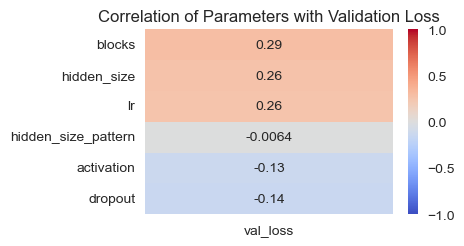

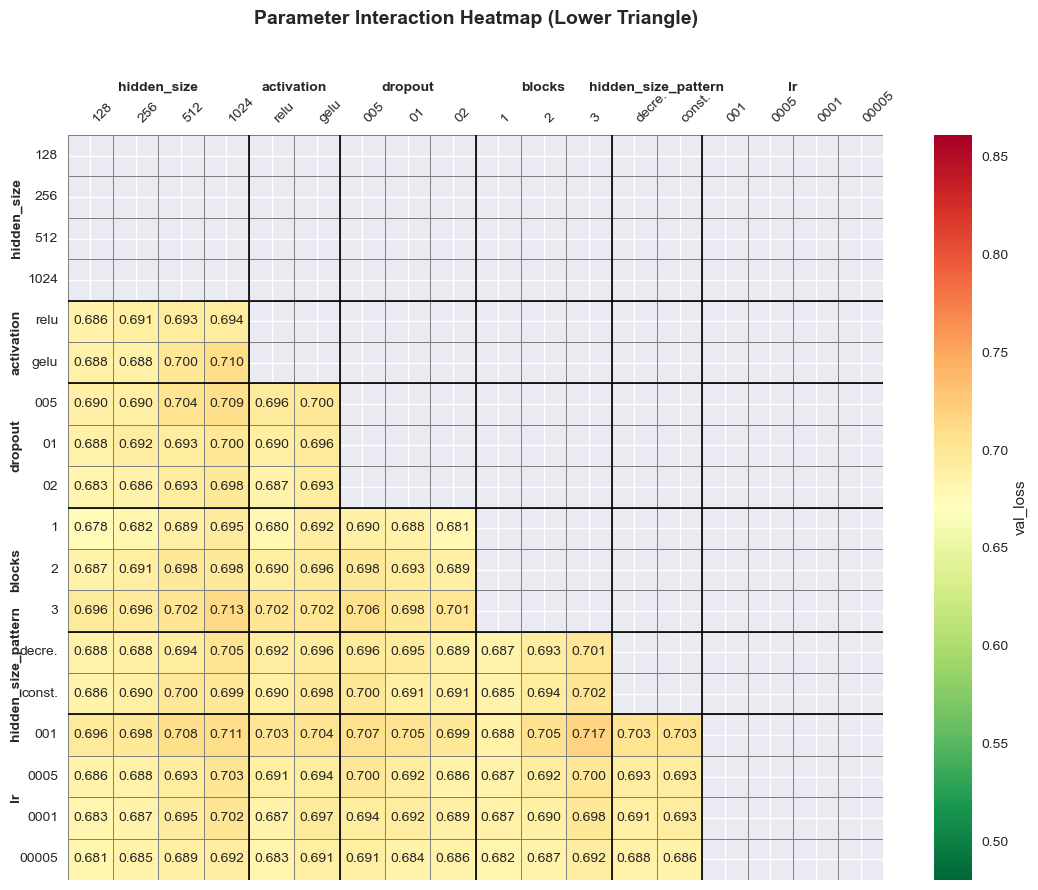



📈 Tuning results for BERT + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
157,relu,2,0.10,1024,constant,0.005,0.549931,0.583735,0.727749,0.360660,0.351970,0.351988
213,relu,3,0.05,512,constant,0.005,0.459497,0.586424,0.722513,0.457488,0.481835,0.468261
165,relu,2,0.20,128,constant,0.005,0.503004,0.593179,0.722513,0.465805,0.539347,0.491368
32,relu,1,0.10,128,decreasing,0.010,0.591982,0.595514,0.738220,0.375155,0.352032,0.352545
282,relu,3,0.20,1024,decreasing,0.001,0.499487,0.596489,0.743455,0.493152,0.489039,0.490414



Top 5 by accuracy_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,accuracy_0,precision_0,recall_0,f1_0
481,gelu,3,0.05,128,decreasing,0.005,0.478839,0.643261,0.774869,0.523518,0.494889,0.500651
204,relu,3,0.05,256,constant,0.010,0.407210,0.658685,0.769634,0.378506,0.381958,0.379461
4,relu,1,0.05,128,constant,0.010,0.386092,0.617724,0.769634,0.483902,0.505480,0.493090
312,gelu,1,0.05,1024,decreasing,0.010,0.415193,0.637039,0.764398,0.543845,0.497660,0.516557
502,gelu,3,0.05,512,constant,0.001,0.461097,0.646770,0.764398,0.471625,0.433067,0.445811


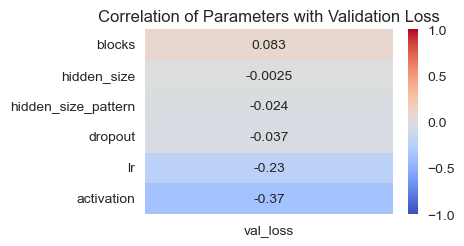

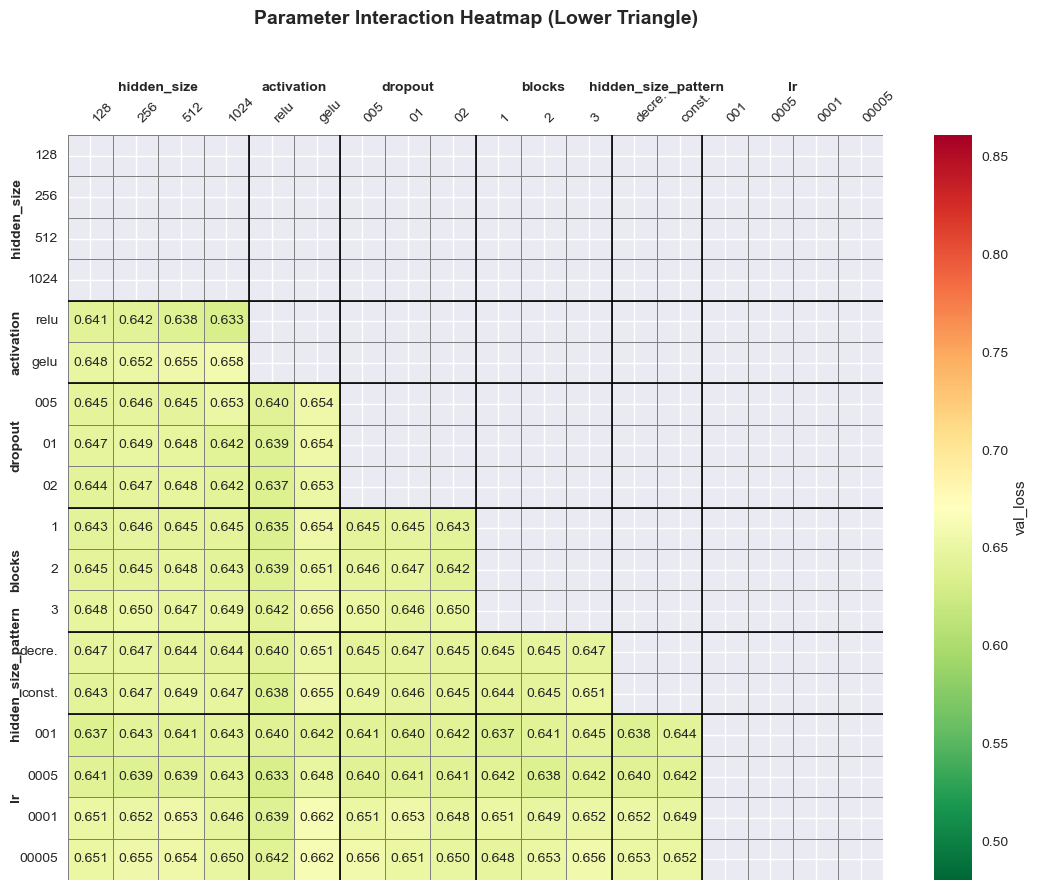

In [18]:
all_val_losses = pd.concat([tuning_history["val_loss"] for tuning_history in tuning_histories.values()])
val_loss_range = (all_val_losses.min(), all_val_losses.max())
print(val_loss_range)
for ft, tuning_history in tuning_histories.items():
    print(f"\n\n📈 Tuning results for {ft.upper()} features model:")
    print_tuning_top_results(tuning_history, topN=5, top_by=["val_loss", "accuracy"])

    plot_param_loss_corr(tuning_history, param_grid)
    plot_tuning_heatmap(tuning_history, param_grid, loss_range=val_loss_range)